# Creating a Prediction model for the Train and Test datasets

This model is created using ***allData.csv***.

## Importing the libraries and datasets

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import (Input, Dense, GRU, LSTM, Conv1D, Dropout, Activation,
                                    GlobalAveragePooling1D, Embedding, Bidirectional, BatchNormalization)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Helper Function for Scaling of Values

In [2]:
def ScaleValues(data):
    sc = StandardScaler()
    data = sc.fit_transform(data)
    data = pd.DataFrame(data)
    return data
    pass

## Reading the data

In [3]:
data = pd.read_csv('allData.csv')

In [4]:
data.drop(columns=data.columns[0],inplace=True)
data.head()

Timestamp      EEG.AF3       EEG.F7       EEG.F3      EEG.FC5  \
0  1.598001e+09  4048.718018  4152.307617  4190.256348  4169.230957   
1  1.598001e+09  4052.307617  4152.307617  4192.307617  4168.205078   
2  1.598001e+09  4060.512939  4155.384766  4194.871582  4169.743652   
3  1.598001e+09  4061.538574  4156.410156  4191.794922  4171.282227   
4  1.598001e+09  4053.846191  4149.230957  4186.666504  4166.666504   

        EEG.T7       EEG.P7       EEG.O1       EEG.O2       EEG.P8  \
0  4164.102539  4210.256348  4175.384766  4177.948730  4195.384766   
1  4153.846191  4215.897461  4178.974121  4180.512695  4193.846191   
2  4150.256348  4218.461426  4180.512695  4181.025879  4194.871582   
3  4144.102539  4210.256348  4175.897461  4177.948730  4198.461426   
4  4142.563965  4206.153809  4171.794922  4174.358887  4198.974121   

        EEG.T8      EEG.FC6       EEG.F4       EEG.F8      EEG.AF4  \
0  4176.410156  4188.717773  4203.589844  3986.153809  3181.538574   
1  4172.307617  4189.743652  4204.615234  3985.641113  3189.230713   
2  4173.846191  4189.743652  4205.641113  3987.692383  3196.923096   
3  4177.436035  4186.666504  4205.641113  3987.179443  3202.051270   
4  4169.743652  4182.563965  4200.512695  3976.923096  3205.641113   

   MarkerValueInt  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

### Dropping unrequired rows

Rows with *MarkerValueInt* equal to 3 or 4 are dropped as the mode is being trained on 3 classes,
```
0. Nothing[Neither of the 2 below]
1. Eye Blink
2. Jaw Clench
```

In [5]:
drop_idx = data.index[(data['MarkerValueInt'] == 1) | (data['MarkerValueInt'] == 3)]
drop_idx

Int64Index([525, 2445, 3081, 5002], dtype='int64')

In [6]:
data.drop(drop_idx,inplace=True)
data.index[data.index[(data['MarkerValueInt'] == 1) | (data['MarkerValueInt'] == 3)]]

Int64Index([], dtype='int64')

### One Hot Encoding

The output column *MarkerValueInt* is one-hot-encoded so that there is no incremental bias present in the dataset while training the model.

In [7]:
data = pd.get_dummies(data, columns=['MarkerValueInt'])
data.head()

Timestamp      EEG.AF3       EEG.F7       EEG.F3      EEG.FC5  \
0  1.598001e+09  4048.718018  4152.307617  4190.256348  4169.230957   
1  1.598001e+09  4052.307617  4152.307617  4192.307617  4168.205078   
2  1.598001e+09  4060.512939  4155.384766  4194.871582  4169.743652   
3  1.598001e+09  4061.538574  4156.410156  4191.794922  4171.282227   
4  1.598001e+09  4053.846191  4149.230957  4186.666504  4166.666504   

        EEG.T7       EEG.P7       EEG.O1       EEG.O2       EEG.P8  \
0  4164.102539  4210.256348  4175.384766  4177.948730  4195.384766   
1  4153.846191  4215.897461  4178.974121  4180.512695  4193.846191   
2  4150.256348  4218.461426  4180.512695  4181.025879  4194.871582   
3  4144.102539  4210.256348  4175.897461  4177.948730  4198.461426   
4  4142.563965  4206.153809  4171.794922  4174.358887  4198.974121   

        EEG.T8      EEG.FC6       EEG.F4       EEG.F8      EEG.AF4  \
0  4176.410156  4188.717773  4203.589844  3986.153809  3181.538574   
1  4172.307617  4189.743652  4204.615234  3985.641113  3189.230713   
2  4173.846191  4189.743652  4205.641113  3987.692383  3196.923096   
3  4177.436035  4186.666504  4205.641113  3987.179443  3202.051270   
4  4169.743652  4182.563965  4200.512695  3976.923096  3205.641113   

   MarkerValueInt_0.0  MarkerValueInt_22.0  MarkerValueInt_23.0  
0                   1                    0                    0  
1                   1                    0                    0  
2                   1                    0                    0  
3                   1                    0                    0  
4                   1                    0                    0

In [8]:
data.columns

Index(['Timestamp', 'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7',
       'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
       'EEG.F8', 'EEG.AF4', 'MarkerValueInt_0.0', 'MarkerValueInt_22.0',
       'MarkerValueInt_23.0'],
      dtype='object')

In [9]:
data.columns = ['Timestamp', 'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7',
       'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
       'EEG.F8', 'EEG.AF4', '0', '22',
       '23']
data.head()

Timestamp      EEG.AF3       EEG.F7       EEG.F3      EEG.FC5  \
0  1.598001e+09  4048.718018  4152.307617  4190.256348  4169.230957   
1  1.598001e+09  4052.307617  4152.307617  4192.307617  4168.205078   
2  1.598001e+09  4060.512939  4155.384766  4194.871582  4169.743652   
3  1.598001e+09  4061.538574  4156.410156  4191.794922  4171.282227   
4  1.598001e+09  4053.846191  4149.230957  4186.666504  4166.666504   

        EEG.T7       EEG.P7       EEG.O1       EEG.O2       EEG.P8  \
0  4164.102539  4210.256348  4175.384766  4177.948730  4195.384766   
1  4153.846191  4215.897461  4178.974121  4180.512695  4193.846191   
2  4150.256348  4218.461426  4180.512695  4181.025879  4194.871582   
3  4144.102539  4210.256348  4175.897461  4177.948730  4198.461426   
4  4142.563965  4206.153809  4171.794922  4174.358887  4198.974121   

        EEG.T8      EEG.FC6       EEG.F4       EEG.F8      EEG.AF4  0  22  23  
0  4176.410156  4188.717773  4203.589844  3986.153809  3181.538574  1   0   0  
1  4172.307617  4189.743652  4204.615234  3985.641113  3189.230713  1   0   0  
2  4173.846191  4189.743652  4205.641113  3987.692383  3196.923096  1   0   0  
3  4177.436035  4186.666504  4205.641113  3987.179443  3202.051270  1   0   0  
4  4169.743652  4182.563965  4200.512695  3976.923096  3205.641113  1   0   0

## Splitting into input and output datasets

In [10]:
X, y = data.iloc[:,:-3], data.iloc[:,-3:]

Binarizing the labels and calculating their respective weights as the classes are heavily imbalanced. This is preferred over upsampling, or downsampling as they may result in incorrect values while using Time Series Generators.

In [11]:
le = LabelBinarizer()
labels = le.fit_transform(y)
counts = labels.sum(axis=0)

classTotals = labels.sum(axis=0)
classWeight = {}

for i in range(0,len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

classWeight

{0: 1.0, 1: 14.493607954545455, 2: 16.78207236842105}

In [12]:
timestamp = X.loc[:,"Timestamp"]
X.drop(columns='Timestamp',inplace=True)
X = ScaleValues(X)
X.head()

0         1         2         3         4         5         6  \
0 -2.221439 -0.397679  0.159069 -0.417371 -0.105974  1.328444 -0.610459   
1 -2.164532 -0.397679  0.328725 -0.438848 -0.150984  1.666367 -0.432773   
2 -2.034452 -0.363680  0.540785 -0.406638 -0.166738  1.819958 -0.356607   
3 -2.018192 -0.352350  0.286321 -0.374429 -0.193744  1.328444 -0.585079   
4 -2.140141 -0.431674 -0.137840 -0.471057 -0.200496  1.082687 -0.788170   

          7         8         9        10        11        12         13  
0 -0.841485  0.244271 -0.147564 -0.052377  0.123648 -0.988613 -13.989228  
1 -0.652138  0.171791 -0.190958 -0.012671  0.156961 -0.991063 -13.882352  
2 -0.614239  0.220096 -0.174684 -0.012671  0.190290 -0.981264 -13.775474  
3 -0.841485  0.389208 -0.136713 -0.131769  0.190290 -0.983714 -13.704222  
4 -1.106593  0.413361 -0.218078 -0.290554  0.023676 -1.032709 -13.654344

In [13]:
X.insert(0,'Timestamp',timestamp)
X.head()

Timestamp         0         1         2         3         4         5  \
0  1.598001e+09 -2.221439 -0.397679  0.159069 -0.417371 -0.105974  1.328444   
1  1.598001e+09 -2.164532 -0.397679  0.328725 -0.438848 -0.150984  1.666367   
2  1.598001e+09 -2.034452 -0.363680  0.540785 -0.406638 -0.166738  1.819958   
3  1.598001e+09 -2.018192 -0.352350  0.286321 -0.374429 -0.193744  1.328444   
4  1.598001e+09 -2.140141 -0.431674 -0.137840 -0.471057 -0.200496  1.082687   

          6         7         8         9        10        11        12  \
0 -0.610459 -0.841485  0.244271 -0.147564 -0.052377  0.123648 -0.988613   
1 -0.432773 -0.652138  0.171791 -0.190958 -0.012671  0.156961 -0.991063   
2 -0.356607 -0.614239  0.220096 -0.174684 -0.012671  0.190290 -0.981264   
3 -0.585079 -0.841485  0.389208 -0.136713 -0.131769  0.190290 -0.983714   
4 -0.788170 -1.106593  0.413361 -0.218078 -0.290554  0.023676 -1.032709   

          13  
0 -13.989228  
1 -13.882352  
2 -13.775474  
3 -13.704222  
4 -13.654344

The dataset is split between train(70%), validation(20%) and test(10%). The dataset cannot be shuffled as the temporal nature of the dataset will be lost.

In [14]:
train_pos = int(0.7 * data.shape[0])
val_pos = int(0.2 * data.shape[0])
test_pos = int(0.1 * data.shape[0])
train_pos, val_pos, test_pos

(32243, 9212, 4606)

In [15]:
train_data, train_labels = X.iloc[:train_pos, :], y.iloc[:train_pos, :]
val_data, val_labels = X.iloc[train_pos:(train_pos+val_pos),:], y.iloc[train_pos:(train_pos+val_pos),:]

In [57]:
test_data, test_labels = X.iloc[-test_pos:, :], y.iloc[-test_pos:, :]

Only in train_data and val_data, the *Timestamp* column is dropped as Dense layers are being used for predicting each signal. A rolling average prediction is used for finding the timestamps where an *Eye Blink* or *Jaw clench* occured.
I found this to be faster as compared to using Time Series Generators with LSTM and GRU

In [16]:
train_data.drop(columns='Timestamp',inplace=True), val_data.drop(columns='Timestamp',inplace=True)

(None, None)

## Defining the model

### Model Architecture

Layer Number | Consists of
------------ | -----------
1 | Dense Layer consisting of 16 units, followed by a ReLu activation layer, BatchNormalization and Dropout(0.25).
2 | Dense Layer consisting of 32 units, followed by a ReLu activation layer, BatchNormalization and Dropout(0.25)
3 | Dense Layer consisting of 64 units, followed by a ReLu activation layer, BatchNormalization and Dropout(0.25)
4 | Dense Layer consisting of 3 units, followed by a Softmax activation layer. The 3 units represent the number of classes for classification.

In [42]:
def class_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    X = Dense(units=16)(X_input)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.25)(X)
    
    X = Dense(units=32)(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.25)(X)
    
    X = Dense(units=64)(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.25)(X)
    
#     X = Dense(units=128)(X)
#     X = Activation("relu")(X)
#     X = BatchNormalization()(X)
#     X = Dropout(0.25)(X)
    
    X = Dense(units=classes)(X)
    X = Activation("softmax")(X)
    
    model = Model(inputs=X_input, outputs=X,name='Dense_Model')
    
    return model
    pass

In [43]:
model1 = class_model(train_data.shape[1],classes=3)
model1.summary()

Model: "Dense_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                240       
_________________________________________________________________
activation_14 (Activation)   (None, 16)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)                64        
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                544       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                

### Learning Rate

A *cyclical* learning rate(CLR) is used for training this dataset. This allows the model to jump out of any local minima if encountered as compared to using a fixed dataset. The learning rate oscillates between a base learning rate(LR) and maximum LR. There are 3 modes,

Mode | Function
---- | --------
triangular | The base and maximum LR remain constant over the training time.
triangular2 | The base LR remains constant while the maximum LR is reduced by half after every cycle.
exp_mode | The base LR remains constant while the maximum LR decreases exponentially.

In [19]:
class CyclicLR(Callback):
    
    def __init__(self, base_lr=0.0001,max_lr=0.001,step_size=2000.,mode="triangular",
              gamma=1.,scale_fn=None, scale_mode='cycle'):
        
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x:1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history_lr = {}
        
        self._reset()
        pass
    
    
    def _reset(self, new_base_lr=None,new_max_lr=None,new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        
        self.clr_iterations = 0.
        pass
    
    
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        pass
    
    def on_train_begin(self, logs={}):
        
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
        pass
    
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        
        self.history_lr.setdefault('lr',[]).append(K.get_value(self.model.optimizer.lr))
        self.history_lr.setdefault('iterations', []).append(self.trn_iterations)
        
        for (k,v) in logs.items():
            self.history_lr.setdefault(k, []).append(v)
            pass
        
        K.set_value(self.model.optimizer.lr, self.clr())
        pass

In [44]:
opt1 = Adam(lr=1e-4)
model1.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])

This model was trained on 200 epochs with a cyclical learning rate with mode as *triangular*.

In [45]:
batchSize = 16
numEpochs = 200

clr = CyclicLR(base_lr=0.0001,max_lr=0.001,step_size=2000.,mode='triangular')

history1 = model1.fit(train_data,train_labels,
                      batch_size=batchSize,
                      verbose=1,
                      epochs=numEpochs,
                      validation_data=(val_data,val_labels),
                      class_weight=classWeight,
                      callbacks=[clr]) 

Epoch 1/100
2016/2016 [==============================] - 8s 4ms/step - loss: 2.4556 - accuracy: 0.6150 - val_loss: 0.4321 - val_accuracy: 0.8982
Epoch 2/100
2016/2016 [==============================] - 8s 4ms/step - loss: 1.5782 - accuracy: 0.7664 - val_loss: 0.4120 - val_accuracy: 0.9005
Epoch 3/100
2016/2016 [==============================] - 7s 4ms/step - loss: 1.4106 - accuracy: 0.7954 - val_loss: 0.3697 - val_accuracy: 0.9005
Epoch 4/100
2016/2016 [==============================] - 7s 4ms/step - loss: 1.3189 - accuracy: 0.8034 - val_loss: 0.3859 - val_accuracy: 0.9043
Epoch 5/100
2016/2016 [==============================] - 8s 4ms/step - loss: 1.2335 - accuracy: 0.8218 - val_loss: 0.3955 - val_accuracy: 0.8832
Epoch 6/100
2016/2016 [==============================] - 8s 4ms/step - loss: 1.1947 - accuracy: 0.8201 - val_loss: 0.3893 - val_accuracy: 0.9005
Epoch 7/100
2016/2016 [==============================] - 7s 4ms/step - loss: 1.1446 - accuracy: 0.8234 - val_loss: 0.4167 - val_ac

2016/2016 [==============================] - 7s 3ms/step - loss: 0.8907 - accuracy: 0.8555 - val_loss: 0.3753 - val_accuracy: 0.8973
Epoch 58/100
2016/2016 [==============================] - 7s 3ms/step - loss: 0.8696 - accuracy: 0.8530 - val_loss: 0.3635 - val_accuracy: 0.9068
Epoch 59/100
2016/2016 [==============================] - 7s 3ms/step - loss: 0.9104 - accuracy: 0.8552 - val_loss: 0.3655 - val_accuracy: 0.8957
Epoch 60/100
2016/2016 [==============================] - 7s 3ms/step - loss: 0.8777 - accuracy: 0.8546 - val_loss: 0.3766 - val_accuracy: 0.8887
Epoch 61/100
2016/2016 [==============================] - 7s 3ms/step - loss: 0.9134 - accuracy: 0.8511 - val_loss: 0.3672 - val_accuracy: 0.8866
Epoch 62/100
2016/2016 [==============================] - 7s 3ms/step - loss: 0.8783 - accuracy: 0.8516 - val_loss: 0.3672 - val_accuracy: 0.8927
Epoch 63/100
2016/2016 [==============================] - 7s 3ms/step - loss: 0.8836 - accuracy: 0.8564 - val_loss: 0.3630 - val_accuracy

In [22]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

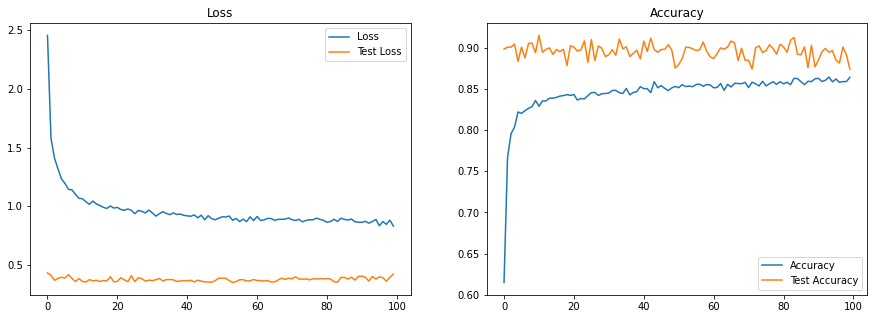

In [46]:
show_final_history(history1)

## Printing the Confusion Matrix

In [24]:
class_labels = {'Nothing':0,'Eye_Blink':22,'Jaw_Clench':23}
list(class_labels.keys())

['Nothing', 'Eye_Blink', 'Jaw_Clench']

In [25]:
y_test = val_labels.values.argmax(axis=1)
y_test.shape

(9212,)

In [47]:
val_pred = model1.predict(val_data)
y_pred = np.argmax(val_pred,axis=1)
y_pred.shape

(9212,)

<Figure size 432x288 with 0 Axes>

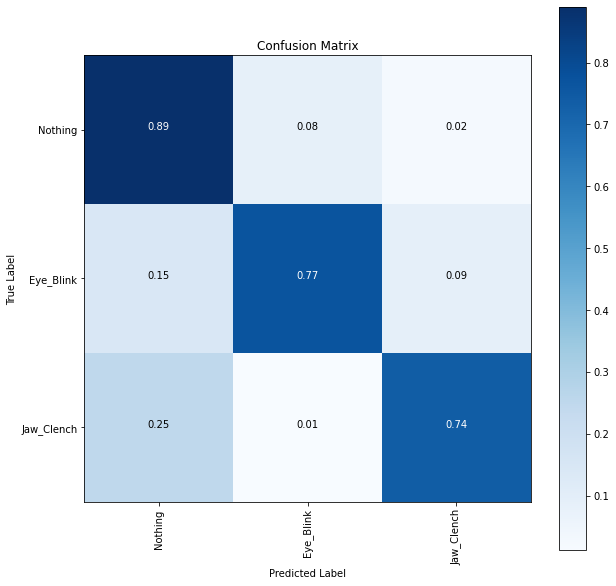

In [48]:
import itertools

class_names = list(class_labels.keys())

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

In [49]:
model1.evaluate(val_data,val_labels)

288/288 [==============================] - 0s 1ms/step - loss: 0.4229 - accuracy: 0.8735


[0.42294490337371826, 0.8735345005989075]

In [52]:
model1.save("eeg_model.h5")

## Loading the saved model for prediction

The model saved in *eeg_model.h5* file is loaded for predicting on the test dataset.

In [53]:
model = load_model("eeg_model.h5")

In [79]:
test_without_timestamp = test_data.iloc[:,1:]
test_pred = model.predict(test_without_timestamp)
test_pred = np.argmax(test_pred, axis=1)
test_pred.shape

(4606,)

In [80]:
np.unique(test_pred, return_counts=True)

(array([0, 1, 2]), array([3626,  597,  383]))

In [81]:
test_pred = pd.DataFrame(test_pred)
test_data.reset_index(drop=True,inplace=True)
test_data['Prediction'] = test_pred

In [82]:
test_data.head()

Timestamp         0         1         2         3         4         5  \
0  1.598001e+09 -0.335312 -0.295685  0.455977  0.033520 -0.970170  2.587970   
1  1.598001e+09 -0.343440 -0.250356  0.159069  0.216034 -1.066942  2.649394   
2  1.598001e+09 -0.335312 -0.205027  0.371129  0.280443 -1.078194  2.649394   
3  1.598001e+09 -0.367832 -0.210691  0.540785  0.162348 -1.197471  2.434350   
4  1.598001e+09 -0.408479 -0.227691  0.752886 -0.063098 -1.323499  2.219334   

          6         7         8         9        10        11        12  \
0  0.328832  0.786987  0.969004  0.329774 -0.508889 -0.259551  0.299973   
1  0.201906  1.089957  0.775739  0.270106 -1.084481 -0.359522  0.226478   
2  0.074980  1.014233  0.727434  0.161621 -1.322659 -0.309537  0.123587   
3 -0.102731  0.218910  0.703282  0.259255 -1.501287 -0.426165 -0.001352   
4 -0.204277  0.256772  0.534169  0.329774 -1.838720 -0.659406 -0.072394   

         13  Prediction  
0 -0.372984           0  
1 -0.330236           0  
2 -0.358737           0  
3 -0.401484           0  
4 -0.401484           0

In [83]:
output_labels = {0:"Nothing",1:"Eye_Blink",2:"Jaw_Clench"}
test_data.replace({"Prediction":output_labels},inplace=True)
test_data.head()

Timestamp         0         1         2         3         4         5  \
0  1.598001e+09 -0.335312 -0.295685  0.455977  0.033520 -0.970170  2.587970   
1  1.598001e+09 -0.343440 -0.250356  0.159069  0.216034 -1.066942  2.649394   
2  1.598001e+09 -0.335312 -0.205027  0.371129  0.280443 -1.078194  2.649394   
3  1.598001e+09 -0.367832 -0.210691  0.540785  0.162348 -1.197471  2.434350   
4  1.598001e+09 -0.408479 -0.227691  0.752886 -0.063098 -1.323499  2.219334   

          6         7         8         9        10        11        12  \
0  0.328832  0.786987  0.969004  0.329774 -0.508889 -0.259551  0.299973   
1  0.201906  1.089957  0.775739  0.270106 -1.084481 -0.359522  0.226478   
2  0.074980  1.014233  0.727434  0.161621 -1.322659 -0.309537  0.123587   
3 -0.102731  0.218910  0.703282  0.259255 -1.501287 -0.426165 -0.001352   
4 -0.204277  0.256772  0.534169  0.329774 -1.838720 -0.659406 -0.072394   

         13 Prediction  
0 -0.372984    Nothing  
1 -0.330236    Nothing  
2 -0.358737    Nothing  
3 -0.401484    Nothing  
4 -0.401484    Nothing

In [84]:
test_data.to_csv("predicted_values.csv")